In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import utils

In [2]:
ROOT_PATH = Path('data/q1b')
OBJ_DATA_PATH = ROOT_PATH / 'ball'
GT_DATA_PATH = OBJ_DATA_PATH / 'gt.npz'
CORRESP_DATA_PATH = OBJ_DATA_PATH / 'corresp.npz'
INTRINSICS_PATH = OBJ_DATA_PATH / 'intrinsics.npz'
IMG1_PATH = OBJ_DATA_PATH / 'image1.jpg'
IMG2_PATH = OBJ_DATA_PATH / 'image2.jpg'

In [3]:
IMG1 = utils.load_image(IMG1_PATH)
IMG2 = utils.load_image(IMG2_PATH)

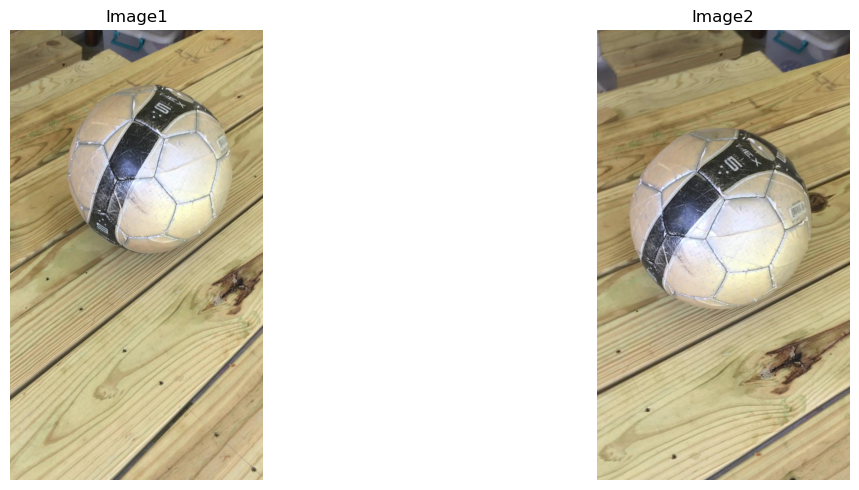

In [4]:
utils.show_images([IMG1, IMG2], ['Image1', 'Image2'])

In [5]:
K1 = np.load(INTRINSICS_PATH)['K1']
K2 = np.load(INTRINSICS_PATH)['K2']
print(f'K1: {K1.shape}\n{K1}')
print(f'K2: {K2.shape}\n{K2}')

K1: (3, 3)
[[1.96456304e+03 0.00000000e+00 5.31500000e+02]
 [0.00000000e+00 1.96456304e+03 9.44000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
K2: (3, 3)
[[1.96515338e+03 0.00000000e+00 5.31000000e+02]
 [0.00000000e+00 1.96515338e+03 9.44000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [6]:
pts1 = np.load(CORRESP_DATA_PATH)['pts1']
pts2 = np.load(CORRESP_DATA_PATH)['pts2']
print(f'pts1: {pts1.shape}\n{pts1}')
print(f'pts2: {pts2.shape}\n{pts2}')

pts1: (7, 2)
[[ 286.63183052  479.56602015]
 [ 388.61617309  488.46462232]
 [ 698.98704348  732.32745652]
 [ 836.437       690.94467391]
 [ 295.50491304 1169.80258696]
 [ 633.95695652 1480.17345652]
 [ 401.91778261  767.79841304]]
pts2: (7, 2)
[[ 168.99502284  649.29602322]
 [ 250.52746234  693.12544798]
 [ 540.67090684 1019.06372282]
 [ 710.14807812  998.8345555 ]
 [  83.02169292 1349.66882652]
 [ 306.72801145 1802.6621387 ]
 [ 234.36384621  978.93733552]]


In [7]:
final_Fs = utils.compute_F_7points(pts1, pts2)
print(f"Fundmental Matrix F ({len(final_Fs)}, 3, 3):\n{final_Fs}")

Fundmental Matrix F (1, 3, 3):
[array([[-3.35078059e-09, -2.91545005e-06, -6.74891733e-03],
       [ 3.51682683e-06, -8.84237457e-07, -1.50044163e-02],
       [ 9.09398538e-03,  1.48748649e-02,  1.00000000e+00]])]


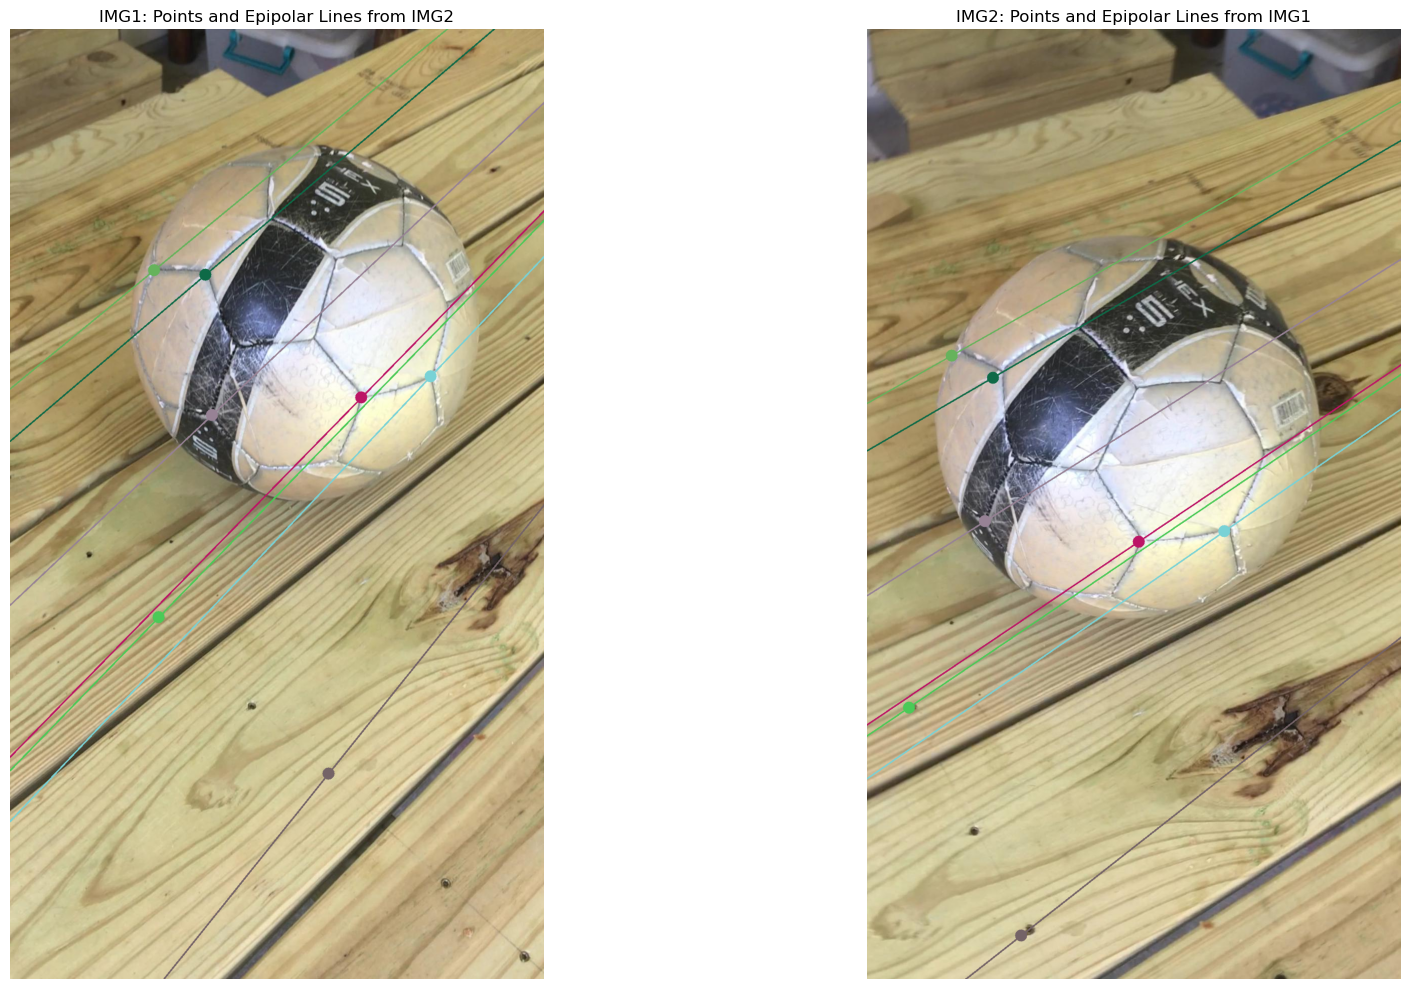

In [8]:
def draw_epipolar_viz(img1, img2, pts1, pts2, F):
    out1 = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2RGB)
    out2 = cv2.cvtColor(img2.copy(), cv2.COLOR_BGR2RGB)
    
    h, w = out1.shape[:2]
    
    pts1_h = np.column_stack((pts1, np.ones(len(pts1))))
    lines2 = (F @ pts1_h.T).T 
    
    pts2_h = np.column_stack((pts2, np.ones(len(pts2))))
    lines1 = (F.T @ pts2_h.T).T

    np.random.seed(42)
    colors = np.random.randint(0, 255, (len(pts1), 3)).tolist()

    for i in range(len(pts1)):
        color = colors[i]
        
        l1 = lines1[i]
        x0, y0 = 0, int(-l1[2] / l1[1])
        x1, y1 = w, int(-(l1[2] + l1[0] * w) / l1[1])
        cv2.line(out1, (x0, y0), (x1, y1), color, 2)
        cv2.circle(out1, tuple(pts1[i].astype(int)), 12, color, -1)
        
        l2 = lines2[i]
        x0, y0 = 0, int(-l2[2] / l2[1])
        x1, y1 = w, int(-(l2[2] + l2[0] * w) / l2[1])
        cv2.line(out2, (x0, y0), (x1, y1), color, 2)
        cv2.circle(out2, tuple(pts2[i].astype(int)), 12, color, -1)

    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(out1)
    plt.title("IMG1: Points and Epipolar Lines from IMG2")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(out2)
    plt.title("IMG2: Points and Epipolar Lines from IMG1")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

draw_epipolar_viz(IMG1, IMG2, pts1, pts2, final_Fs[0])
# draw_epipolar_viz(IMG1, IMG2, pts1, pts2, final_Fs[1])
# draw_epipolar_viz(IMG1, IMG2, pts1, pts2, final_Fs[2])

In [9]:
F = final_Fs[0]
print("Fundmental Matrix F:\n", F)

Fundmental Matrix F:
 [[-3.35078059e-09 -2.91545005e-06 -6.74891733e-03]
 [ 3.51682683e-06 -8.84237457e-07 -1.50044163e-02]
 [ 9.09398538e-03  1.48748649e-02  1.00000000e+00]]


In [10]:
E_raw = K2.T @ F @ K1

U, S, Vt = np.linalg.svd(E_raw)

average_scale = (S[0] + S[1]) / 2.0

E = U @ np.diag([average_scale, average_scale, 0]) @ Vt

print("Essential Matrix E:\n", E)

Essential Matrix E:
 [[-1.29362530e-02 -1.12555838e+01 -1.86746228e+01]
 [ 1.35772998e+01 -3.41374692e+00 -2.74530807e+01]
 [ 2.43843347e+01  2.45414017e+01  1.64166850e+00]]


In [11]:
p1_h = np.array([pts1[0,0], pts1[0,1], 1])
p2_h = np.array([pts2[0,0], pts2[0,1], 1])

p1_norm = np.linalg.inv(K1) @ p1_h
p2_norm = np.linalg.inv(K2) @ p2_h

error = p2_norm.T @ E @ p1_norm
print(f"Error for point 0: {error:.6f}")

Error for point 0: -0.000000
